# Hyper-parameter Optimization

In this notebook hyper-parameters of XGBoost are optimized for [HIGGS](https://archive.ics.uci.edu/ml/datasets/HIGGS) dataset.

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import numpy as np

Here, [scikit-optimize](https://scikit-optimize.github.io/) (skopt) library is used.

In [3]:
from skopt import Optimizer

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, WhiteKernel

from skopt.learning import RandomForestRegressor

from skopt.acquisition import gaussian_ei as acq_func

## Loading data

The original dataset is quite large, thus, in order to save time, only a portion of it is used.

In [4]:
# DATA_ROOT = '/mnt/mlhep2018/datasets/'
DATA_ROOT = '/Users/thomas/mlhep/showmlhep/hyper/'

SAMPLE_LIMIT=100000

In [5]:
import os.path as osp

data = np.genfromtxt(
    osp.join(DATA_ROOT, 'HIGGS.csv'),
    dtype='float32',
    delimiter=',',
    max_rows=SAMPLE_LIMIT
)

X, y = data[:, 1:], data[:, 0]

In [6]:
X.shape

(100000, 28)

In [7]:
y.shape
y[:20]

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1.], dtype=float32)

In [8]:
### again to save training time only 10% of the loaded data is used for training.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5)

## Max depth tuning

For illustration purposes we perform Baysian Optimization on 1 parameter: `learning rate`.

Learning rate in XGBoost can vary dramatically by orders of magnitude, thus, we use *logarithmic scale*.

The goal is to maximize `ROC AUC` (minimize 1 - `ROC AUC`).

In [9]:
def target_function_1(log_learning_rate, X_train=X_train, y_train=y_train, X_score=X_test, y_score=y_test):
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    
    xgb = XGBClassifier(
        max_depth=3, 
        n_estimators=50,
        learning_rate=np.exp(log_learning_rate),
        objective='binary:logistic',
        n_jobs=20,
        reg_lambda=0.0
    )

    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_score)[:, 1]
    
    return 1 - roc_auc_score(y_score, predictions)

In [10]:
### learning rate <- [1.0e-3, 1]
dimensions_1 = [
    (np.log(1.0e-3), 0)
]

In [11]:
%%time

target_function_1(0.0, X_train, y_train, X_val, y_val)

CPU times: user 896 ms, sys: 34.8 ms, total: 931 ms
Wall time: 943 ms


0.25383577482191644

In [9]:
### utility function to inspect status of BO.

def plot_bo(bo, suggestion=None, value=None):
    a, b = bo.space.bounds[0]
    
    ### getting the latest model
    model = bo.models[-1]
    
    xs = np.linspace(a, b, num=100)
    x_model = bo.space.transform(xs.reshape(-1, 1).tolist())
    
    mean, std = model.predict(x_model, return_std=True)
    
    plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(
        np.array(bo.Xi)[:, 0],
        np.array(bo.yi),
        color='red',
        label='observations'
    )
    if suggestion is not None:
        plt.scatter([suggestion], value, color='blue', label='suggestion')
    
    plt.plot(xs, mean, color='green', label='model')
    plt.fill_between(xs, mean - 1.96 * std, mean + 1.96 * std, alpha=0.1, color='green')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    acq = acq_func(x_model, model, np.min(bo.yi))
    plt.plot(xs, acq, label='Expected Improvement')
    plt.legend()
    
    plt.show()

In [10]:
### another utility function
def cum_min(xs):
    result = np.zeros_like(xs)
    cmin = xs[0]
    
    result[0] = xs[0]
    
    for i in range(1, xs.shape[0]):
        if cmin > xs[i]:
            cmin = xs[i]

        result[i] = cmin
    
    return result

In [11]:
from IPython import display

### plots progress of BO over time.

def plot_convergence(bo):
    display.clear_output(wait=True)
    values = np.array(bo.yi)
    
    plt.figure(figsize=(12, 6))
    plt.plot(cum_min(values), label='minimal discovered')
    plt.scatter(np.arange(len(bo.yi)), bo.yi, label='observations')
    plt.xlabel('step', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    
    plt.legend(loc='upper right', fontsize=18)
    
    plt.show()

### Bayesian optimization with Gaussian Process

In [19]:
### create an instance of Baysian Optimizer
bo_gp_1 = Optimizer(
    ### telling optimizer boundaries for each parameter
    dimensions=dimensions_1,
    
    ### setting regressor
    base_estimator=GaussianProcessRegressor(
        kernel=RBF(length_scale_bounds=[1.0e-6, 1.0e+6]) + \
            WhiteKernel(noise_level=1.0e-5, noise_level_bounds=[1.0e-6, 1.0e-2]),
    ),
    n_initial_points=2,
    acq_func='EI',   
)

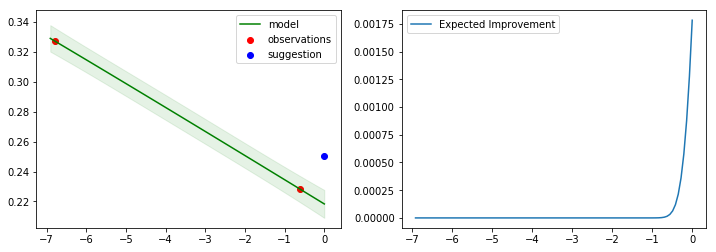

/Users/thomas/mlhep/mlenv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


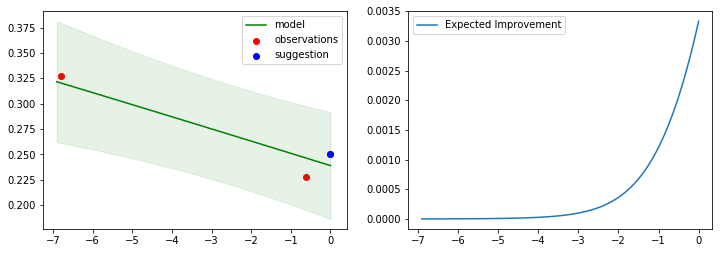

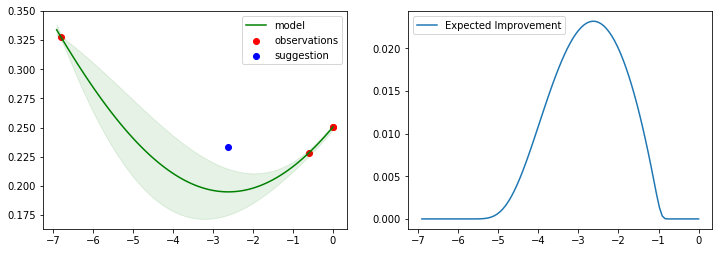

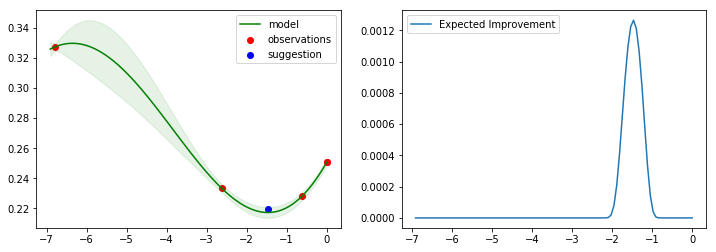

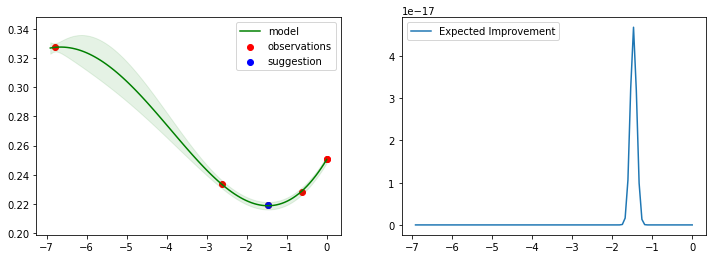

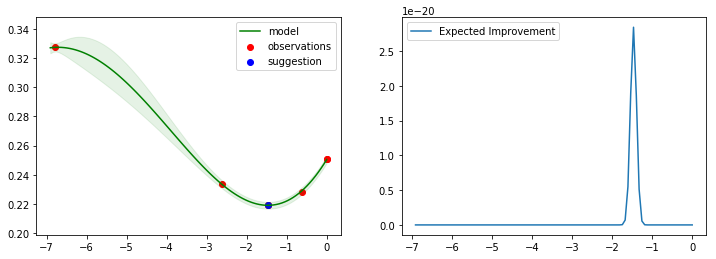

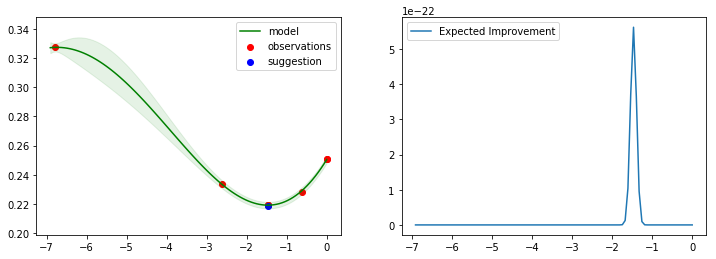

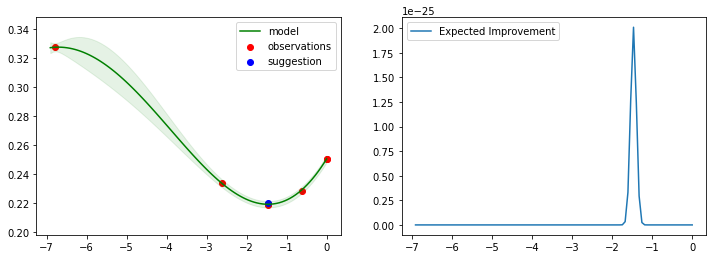

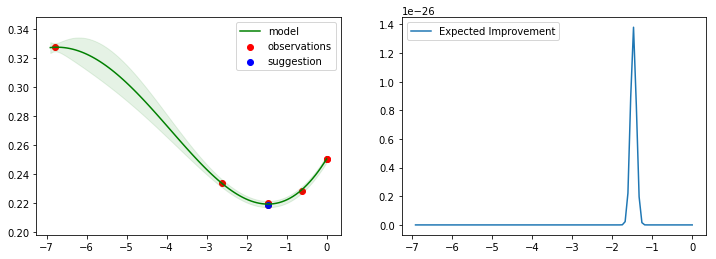

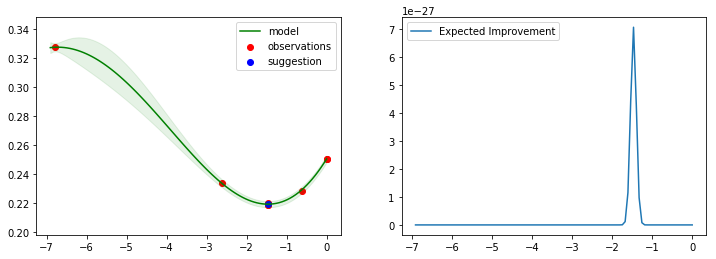

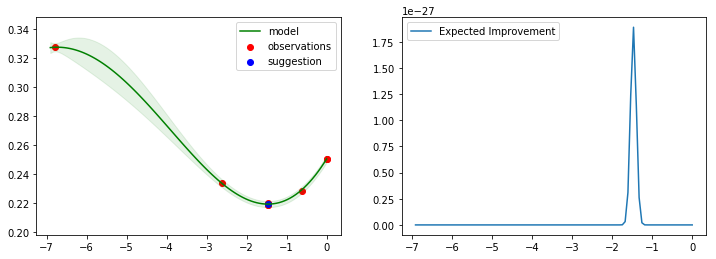

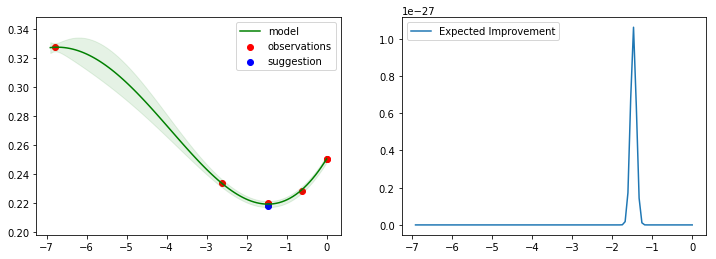

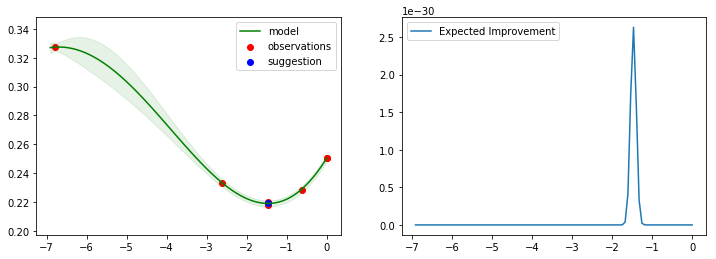

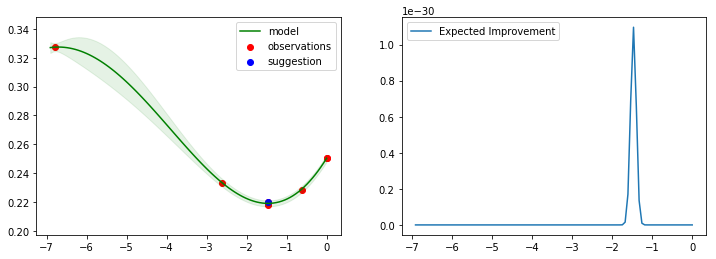

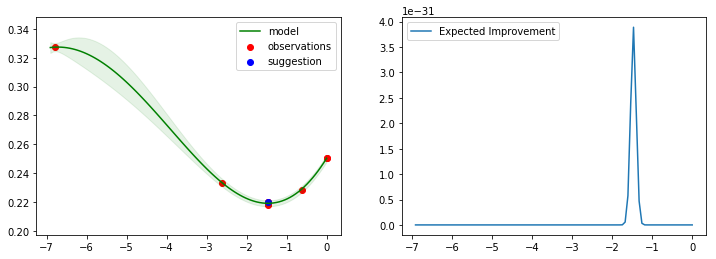

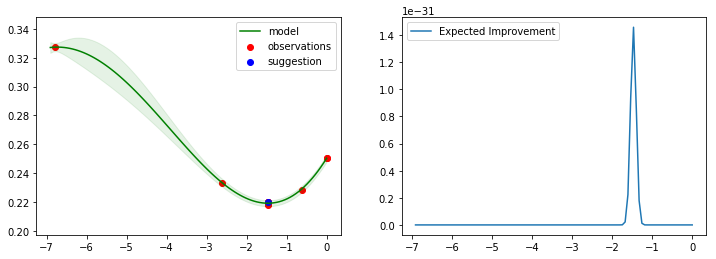

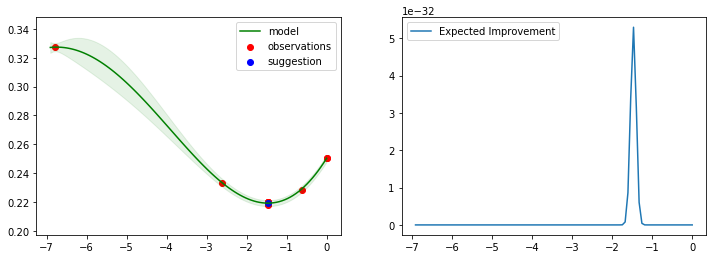

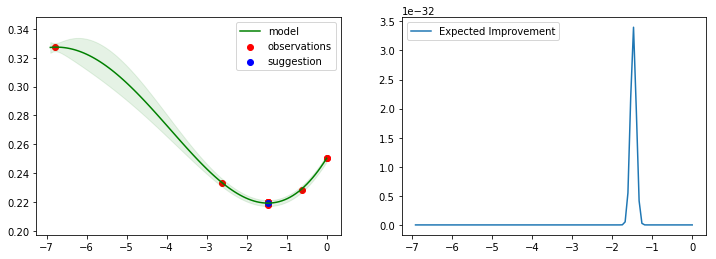

In [20]:
for i in range(20):
    x = bo_gp_1.ask()
    f = target_function_1(x[0], X_train, y_train, X_val, y_val)

    if len(bo_gp_1.models) > 0:
        plot_bo(bo_gp_1, suggestion=x, value=f)
    
    bo_gp_1.tell(x, f)

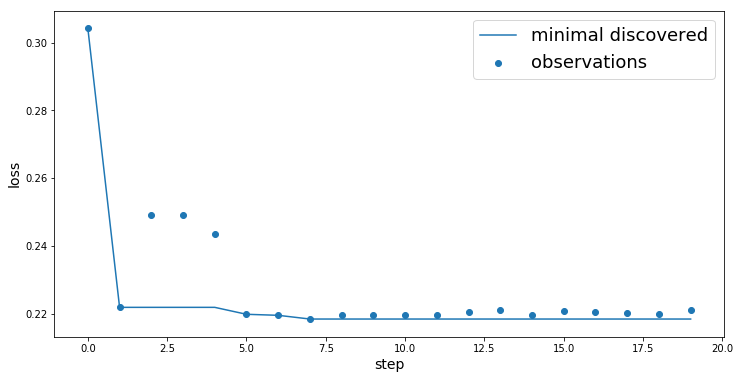

In [17]:
plot_convergence(bo_gp_1)

### Final test

In [18]:
best = np.argmin(bo_gp_1.yi)
best_parameters = bo_gp_1.Xi[best]

print('Best log learning rate: %.2e' % best_parameters[0])

Best log learning rate: -1.41e+00


In [19]:
best_auc = 1 - target_function_1(best_parameters[0], X_train, y_train, X_test, y_test)

print('Best ROC AUC: %.3lf' % best_auc)

Best ROC AUC: 0.787


### Bayesian optimization with Random Forest

In [19]:
### the same but with random forest

bo_rf_1 = Optimizer(
    dimensions=dimensions_1,
    base_estimator=RandomForestRegressor(
        n_estimators=100,
        min_variance=1.0e-6
    ),
    n_initial_points=3,
    acq_func='EI',   
)

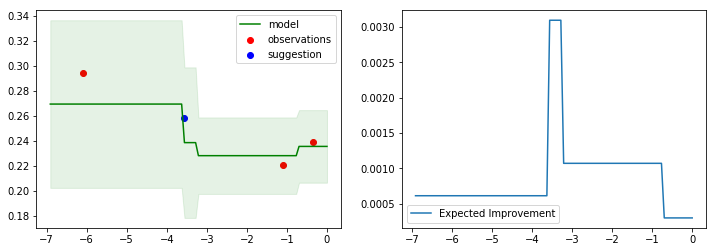

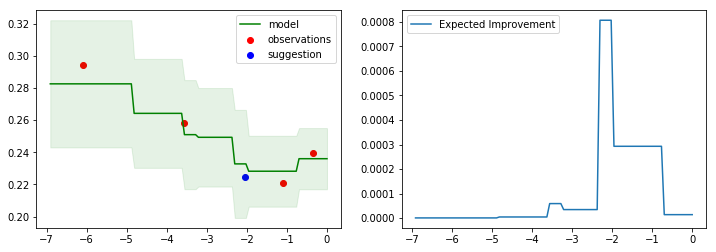

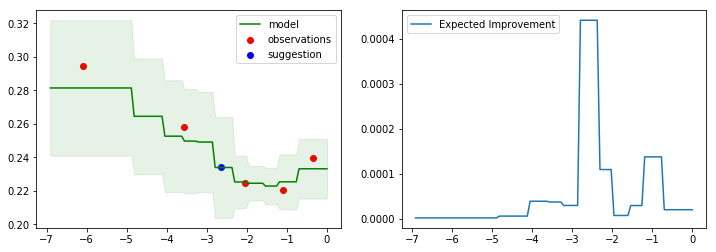

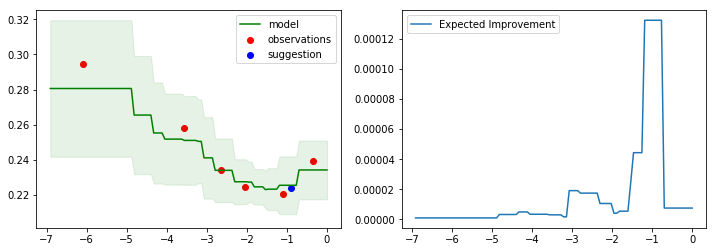

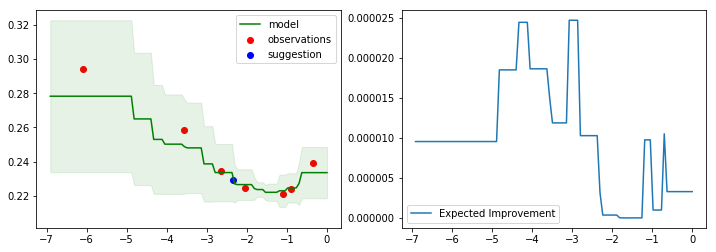

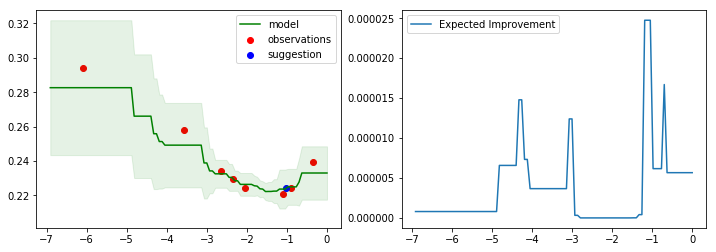

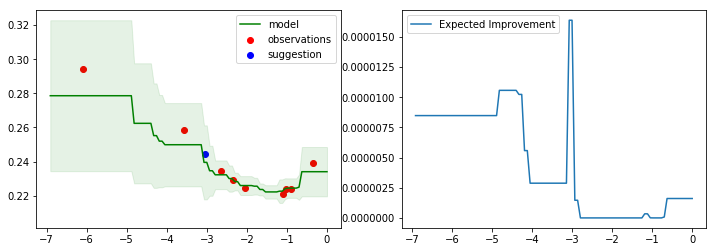

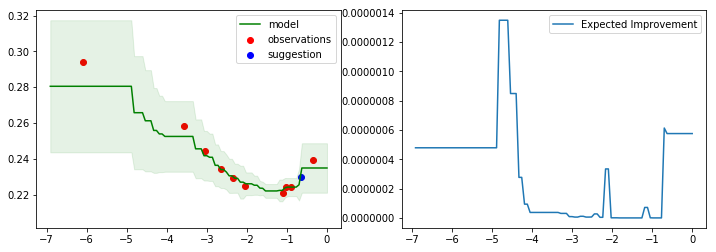

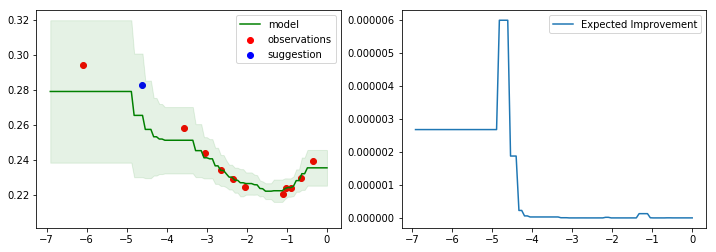

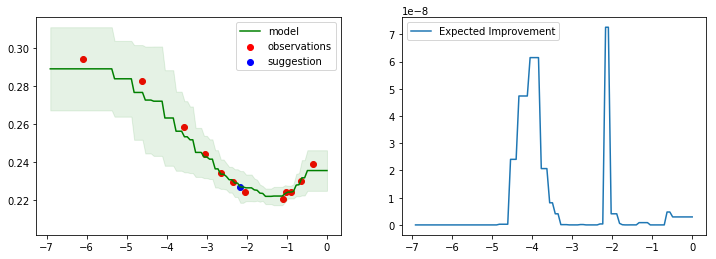

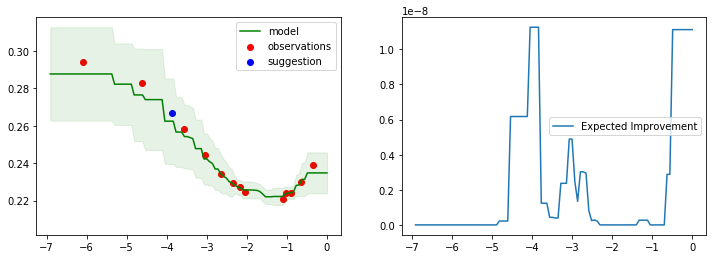

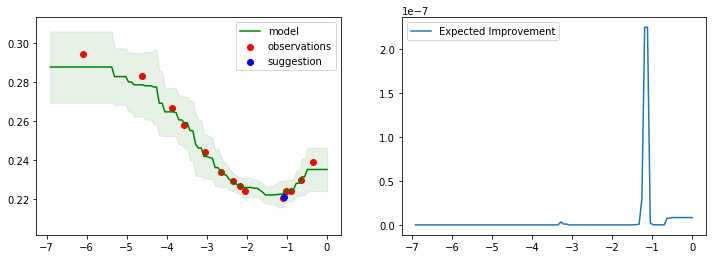

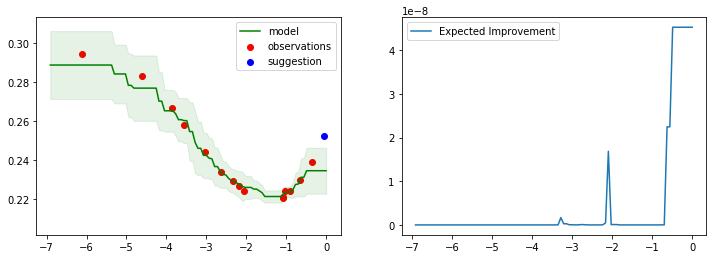

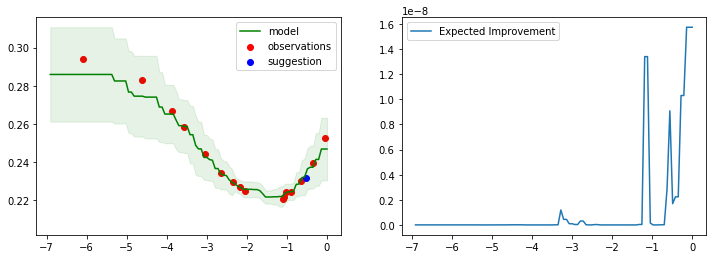

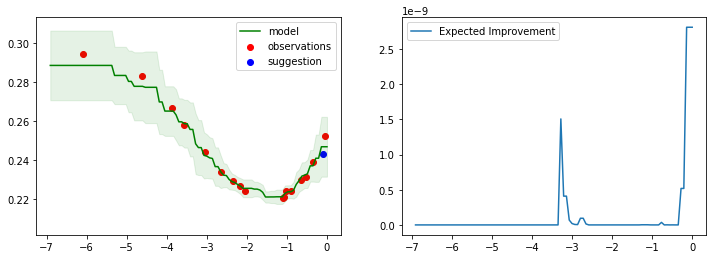

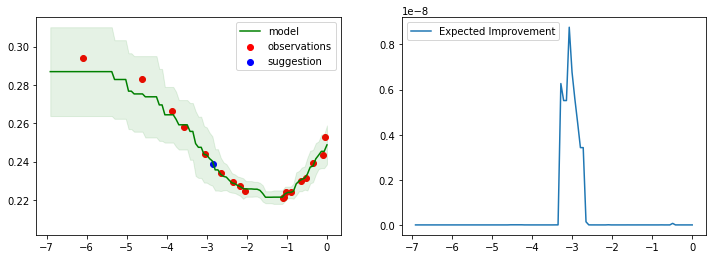

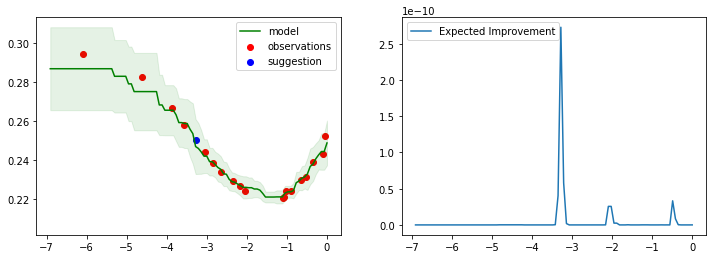

In [20]:
for i in range(20):
    x = bo_rf_1.ask()
    f = target_function_1(x[0])

    if len(bo_rf_1.models) > 0:
        plot_bo(bo_rf_1, suggestion=x, value=f)
    
    bo_rf_1.tell(x, f)

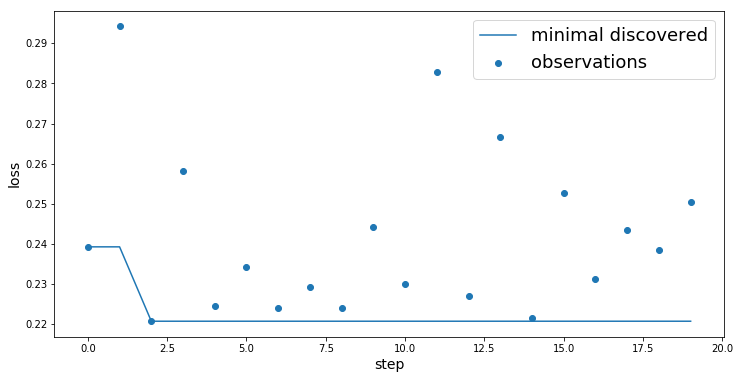

In [21]:
plot_convergence(bo_rf_1)

In [22]:
best = np.argmin(bo_rf_1.yi)
best_parameters = bo_rf_1.Xi[best]

print('Best log learning rate: %.2e' % best_parameters[0])

Best log learning rate: -1.09e+00


In [23]:
best_auc = 1 - target_function_1(best_parameters[0], X_train, y_train, X_test, y_test)

print('Best ROC AUC: %.3lf' % best_auc)

Best ROC AUC: 0.779


## Tuning all important hyper-parameters simultaneously

In [ ]:
def target_function_4(params, X_train, y_train, X_score, y_score):
    """
    params - array with 4 values: [max tree depth, number of estimators, log learning rate, reg_lambda]
    X_train, y_train - training dataset;
    X_score, y_score - dataset for evaluating quality of the classifier;
    
    Returns 1 - ROC AUC evaluated on `X_score` and `y_score`. 
    """
    max_depth, n_estimators, log_learning_rate, reg_lambda = params

    max_depth = int(np.ceil(max_depth))
    n_estimators = int(np.ceil(n_estimators))
    
    learning_rate = np.exp(log_learning_rate)

    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    
    xgb = XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        objective='binary:logistic',
        n_jobs=4
    )
    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_score)[:, 1]
    
    return 1 - roc_auc_score(y_score, predictions)

In [ ]:
def print_best(bo):
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    max_depth, n_estimators, log_learning_rate, reg_lambda = best_parameters
    
    print(
        'Best model:\n\nmax_depth=%d\nn_estimators=%d\nlearning_rate=%.1e\nreg_lambda=%.3lf' % (
            int(np.ceil(max_depth)),
            int(np.ceil(n_estimators)),
            np.exp(log_learning_rate),
            reg_lambda
        )
    )
    
    best_auc = target_function_4(best_parameters, X_train, y_train, X_test, y_test)
    print('Best ROC AUC: %.3lf' % (1 - best_auc))

In [ ]:
dimensions_4 =[
    ### max_depth
    (1.0, 20.0),
    
    ### n_estimators
    (1.0, 500.0),
    
    ### log_learning rate
    (np.log(1.0e-3), np.log(1.0)),
    
    ### l2 reg
    (0.0, 1.0)
]

#### Bayesian Optimization with Gaussian Process

In [ ]:
bo_gp_4 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=GaussianProcessRegressor(
        kernel=RBF(length_scale_bounds=[1.0e-3, 1.0e+3]) +\
            WhiteKernel(noise_level=1.0e-5, noise_level_bounds=[1.0e-6, 1.0e-2])
    ),
    n_initial_points=5,
    acq_func='EI',   
)

In [ ]:
for i in range(50):
    x = bo_gp_4.ask()
    f = target_function_4(x, X_train, y_train, X_val, y_val)
    
    bo_gp_4.tell(x, f)
    
    plot_convergence(bo_gp_4)

In [ ]:
print_best(bo_gp_4)

#### The same with Random forest

In [ ]:
bo_rf_4 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=5,
    acq_func='EI',   
)

In [ ]:
for i in range(50):
    x = bo_rf_4.ask()
    f = target_function_4(x, X_train, y_train, X_val, y_val)
    
    bo_rf_4.tell(x, f)
    
    plot_convergence(bo_rf_4)

In [ ]:
print_best(bo_rf_4)

### Structural Optimization


Sometimes it is preferable to have a good classifier with a particular configuration.

For example, smaller ensemble is preferable to large ones (given the same quality), since small ensemble are faster to compute. One way to find preferable classifiers is to introduce a penalty to the target function:

$$\mathcal{L} = \mathrm{quality\;metric} + \mathrm{penalty}$$


For example, number of CPU operations per prediction can introduced as a penalty: 
$$\mathcal{L} = \mathrm{ROC\; AUC} + C \cdot \mathrm{tree\;depth} \cdot \mathrm{ensemble\;size}$$

In [ ]:
def target_function_4_struct(params, X_train, y_train, X_score, y_score):
    """
    params - array with 4 values: [max tree depth, number of estimators, log learning rate, reg_lambda]
    X_train, y_train - training dataset;
    X_score, y_score - dataset for evaluating quality of the classifier;
    
    Returns 1 - ROC AUC evaluated on `X_score` and `y_score`. 
    """
    max_depth, n_estimators, log_learning_rate, reg_lambda = params

    max_depth = int(np.ceil(max_depth))
    n_estimators = int(np.ceil(n_estimators))
    
    learning_rate = np.exp(log_learning_rate)

    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    
    xgb = XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        objective='binary:logistic',
        n_jobs=4
    )
    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_score)[:, 1]
    
    score = 1 - roc_auc_score(y_score, predictions)
    
    penalty = 5.0e-5 * n_estimators * max_depth
    
    return score + penalty 

In [ ]:
bo_gp_4_struct = Optimizer(
    dimensions=dimensions_4,
    base_estimator=GaussianProcessRegressor(
        kernel=RBF(length_scale_bounds=[1.0e-3, 1.0e+3]) +\
            WhiteKernel(noise_level=1.0e-5, noise_level_bounds=[1.0e-6, 1.0e-2])
    ),
    n_initial_points=5,
    acq_func='EI',   
)

In [ ]:
for i in range(100):
    x = bo_gp_4_struct.ask()
    f = target_function_4_struct(x, X_train, y_train, X_val, y_val)
    
    bo_gp_4_struct.tell(x, f)
    
    plot_convergence(bo_gp_4_struct)

In [ ]:
print_best(bo_gp_4_struct)

## Your turn

Try to optimize neural network architecture for the HIGGS dataset.

Your neural network **must** have less than $10^4$ parameters!

Target metric: $\mathrm{ROC\;AUC} \to \max$

**Normal problem**:
- fix number of layers (e.g. 5);
- choose type of the layers, non-linearity etc (e.g. `Dense(activation='relu')`);
- optimize number of units in each layer;
- introduce restrictions on number of parameters, either by:
    - penalty e.g. `C * max(num_parameters - 1.0e+4, 0)`;
    - scaling number of units until number of parameters drops to $10^4$;
    - using fractions of total number of parameters for each layer (see `softmax` trick);
- you may want to also include regularization coefficients (e.g. `alpha * l1 + beta * l2`).

**Mad-data-scientist problem**:
- try to optimize everything:
    - find a way to encode variable number of layers (e.g. by introducing limit on number of layers);
    - find a way to optimize activation function:
        - e.g. by preselecting small set of activation functions and taking linear combination of them;
        - skopt alse can deal with descrite variables (please, refer to the documentation of `dimensions` argument for optimizer);
        - alternatively, you can introduce coeficients for each activation function (select 3-4) for each layers and split your layers according to these coefficients: `Concat(Dense(total_units * coef[0], activation='relu'), Dense(total_units * coef[1], activation='sigmoid'))`.

**You can evaluate on the test set only once!**

Tips:
- try to optimize 1 parameter first, e.g. to select an appropriate kernel for GP, estimate noise level;
-  `sigmoid` and `tanh` does not differ much (there is an easy-to-prove procedure that replaces one with another w/o changing the network);
- if your want to have parameters that sum to one use `softmax` and fix one of the parameters to `1` (to remove overparametrization);
- BO does not handle very well ordered descrete variables, it might be better to use `int(param)`:
    - you might want to use cache in this case.
- use small portion of the dataset e.g. `10^4` examples to accelerate search;
- if you have symmetries in your parameterization, i.e. N parameter values correspond to the same network, you can report to BO all N parameters with the same value.

In [12]:
### don't forget about others!

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
tf_session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
import keras
keras.backend.tensorflow_backend.set_session(tf_session)

from keras.models import Sequential
import keras.layers as L

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [14]:
def get_model(n1, n2, n3):
    model = Sequential(
        layers = [
            L.InputLayer(input_shape=(28, )),
            L.Dense(n1, activation='relu'),
            L.Dense(n2, activation='relu'),
            L.Dense(n3, activation='relu'),
            L.Dense(1, activation='sigmoid')
            ]
        )
    return model

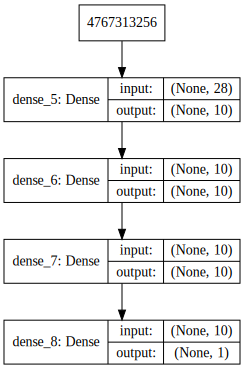

In [16]:
from IPython import display
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
test_model = get_model(10, 10, 10)
SVG(model_to_dot(test_model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
test_model.count_params()

521

In [18]:
def target_function(params):
    n1, n2, n3 = params

    n1 = int(n1)
    n2 = int(n2)
    n3 = int(n3)
    
    model = get_model(n1, n2, n3)    
    
    n_param_threshold = 1e5
    if model.count_params() > n_param_threshold:
        return 1.0

    model.compile('adam', loss='binary_crossentropy')
    model.fit(X_train, y_train, epochs=10)
    
    y_predictions = model.predict_proba(X_val)[:, 0]
    
    roc_auc = roc_auc_score(y_val, y_predictions)

    return 1 - roc_auc

In [19]:
target_function([10, 10, 10])

Epoch 1/10
10000/10000 [==============================] - 1s 83us/step - loss: 0.6945
Epoch 2/10
10000/10000 [==============================] - 1s 56us/step - loss: 0.6888
Epoch 3/10
10000/10000 [==============================] - 1s 50us/step - loss: 0.6827
Epoch 4/10
10000/10000 [==============================] - 1s 51us/step - loss: 0.6740
Epoch 5/10
10000/10000 [==============================] - 1s 50us/step - loss: 0.6632
Epoch 6/10
10000/10000 [==============================] - 0s 50us/step - loss: 0.6543
Epoch 7/10
10000/10000 [==============================] - 0s 49us/step - loss: 0.6477
Epoch 8/10
10000/10000 [==============================] - 0s 49us/step - loss: 0.6423
Epoch 9/10
10000/10000 [==============================] - 1s 50us/step - loss: 0.6392
Epoch 10/10
10000/10000 [==============================] - 1s 52us/step - loss: 0.6372


0.3339122447166345

In [20]:
opt = Optimizer(
    dimensions = [(5, 200), (5, 200), (5, 200)],
    base_estimator = GaussianProcessRegressor(
        kernel = Matern(nu=1.5) + WhiteKernel(noise_level_bounds=(1.0e-3, 1.0e-1))
        ),
    n_initial_points = 3,
    acq_func = 'LCB'
    )

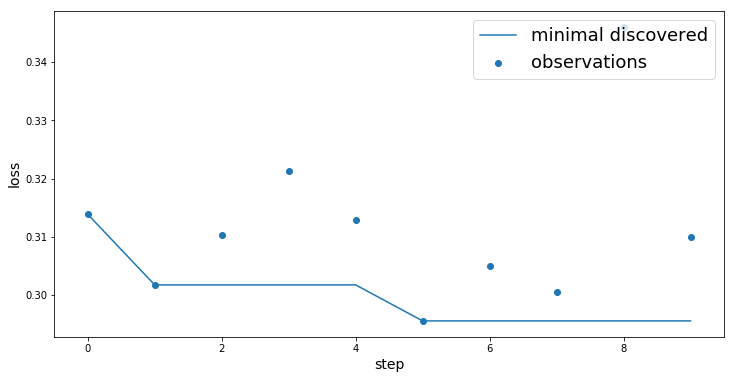

In [21]:
for i in range(10):
    suggestion = opt.ask()
    
    f = target_function(suggestion)
    
    opt.tell(suggestion, f)
    
    plot_convergence(opt)

In [47]:
opt.Xi

[[55, 193, 40],
 [29, 62, 163],
 [143, 143, 78],
 [200, 194, 8],
 [196, 7, 196],
 [193, 200, 9],
 [8, 186, 6],
 [196, 191, 7],
 [200, 14, 6],
 [200, 185, 14],
 [197, 197, 197]]

## What is next?

- you can experiment with acqusition functions:
    - compare expected improvement (`EI`) and lower confidence bound (`LCB`) to probability of improvement (`PI`);
- explore different regressions available https://scikit-optimize.github.io/learning/index.html
- try to shoot yourself in the foot by perfroming naive Bayesian inference on a Neural Network.
- try partial Bayesian Inference with Neural Networks: https://arxiv.org/pdf/1502.05700.pdf
- try REMBO-ing your optimum value: https://arxiv.org/abs/1301.1942

<img src="https://imgix.ranker.com/user_node_img/50066/1001300261/original/there-was-a-big-crew-turnover-in-rambo-iii-photo-u1?w=650&q=50&fm=jpg&fit=crop&crop=faces" width=454 height=193>